In [1]:
import sys
sys.path.append("../v3-polars")

%load_ext autoreload
%autoreload 2

from v3 import state
import numpy as np

import polars as pl

from datetime import date, timedelta, datetime, timezone
import math
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [2]:
WETH = ['0x82aF49447D8a07e3bd95BD0d56f35241523fBab1'.lower(), 
        '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'.lower()]

In [3]:
starting = datetime(year = 2023, month = 3, day = 1)

address = '0xc31e54c7a869b9fcbecc14363cf510d1c41fa443'
arb = state.v3Pool(address, 'arbitrum', update = True)
priceArb = arb.getPriceSeries(starting, frequency = '15m', gas = True)

address = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'
eth = state.v3Pool(address, 'ethereum', update = True)
priceEth = eth.getPriceSeries(starting, frequency = '15m', gas = True)


Starting table uniswap_v3_factory_pool_created_events_combined
Found 185 to 187052119
Found data saved
Updated to 187052120 to 187052119
Nothing to update
Starting table uniswap_v3_pool_swap_events_combined
Found 188 to 187054792
Found data saved
Updated to 187054793 to 187054792
Nothing to update
Starting table uniswap_v3_pool_mint_burn_events_combined
Found 185 to 186836545
Found data saved
Updated to 186836546 to 186836545
Nothing to update
Starting table uniswap_v3_pool_initialize_events_combined
Found 185 to 186701082
Found data saved
Updated to 186701083 to 186701082
Nothing to update


PARTITIONED DS: estimated cardinality: 0.9995722 exceeded the boundary: 0.4, running default HASH AGGREGATION
PARTITIONED DS: estimated cardinality: 0.9991068 exceeded the boundary: 0.4, running default HASH AGGREGATION


Starting table uniswap_v3_factory_pool_created_events_combined
Found 12369739 to 19362254
Found data saved
Updated to 19354591 to 19362254
Starting at 19354591
Going from 19354591 to 19362254
Starting table uniswap_v3_pool_swap_events_combined
Found 12369879 to 19362850
Found data saved
Updated to 19354802 to 19362850
Starting at 19354802
Going from 19354802 to 19362850
Starting table uniswap_v3_pool_mint_burn_events_combined
Found 12369739 to 19358079
Found data saved
Updated to 19350910 to 19358079
Starting at 19350910
Going from 19350910 to 19358079
Starting table uniswap_v3_pool_initialize_events_combined
Found 12369739 to 19356725
Found data saved
Updated to 19349535 to 19356725
Starting at 19349535
Going from 19349535 to 19356725


PARTITIONED DS: estimated cardinality: 0.9975132 exceeded the boundary: 0.4, running default HASH AGGREGATION
PARTITIONED DS: estimated cardinality: 1 exceeded the boundary: 0.4, running default HASH AGGREGATION


In [4]:
def tokenNotWETH(pool, WETH):
    if pool.token0 in WETH:
        USDC = pool.token1
    elif pool.token1 in WETH:
        USDC = pool.token0
    else:
        raise ValueError("Token missing from WETH array")
        
    return USDC

def verbose_print(string, verbose):
    if verbose:
        print(string)
        
def binary_search_calldata(guessPrev, guessHigh, l1Calldata, l2Calldata, 
                          top_depth = 50, verbose = True):
    depth = 0
    search = True
    largest_spread = 1e12
    
    while search:     
        guessMid = (guessPrev + guessHigh) / 2
        
        l1Calldata['swapIn'] = guessMid
        l2Calldata['swapIn'] = guessMid

        l1AmtOut, l1Values = eth.swapIn(l1Calldata)
        l2AmtOut, l2Values = arb.swapIn(l2Calldata)
        
        l2AdjAmtOut = l2AmtOut - l2Gas
        l1AdjAmtOut = l1AmtOut - l1Gas
        spr = (l1AdjAmtOut - l2AdjAmtOut)
        
        (firstL1, secondL1, _) = l1Values
        
        (firstL2, secondL2, _) = l2Values
        if spr < -1 * largest_spread:
            verbose_print(f"Search low - New grid of {guessMid} to {guessHigh}", verbose)
            
            intPartMid = math.modf(guessMid)[1]
            intPartHigh = math.modf(guessHigh)[1]
            if intPartMid == intPartHigh:
                return (guessMid, l1Gas, l2Gas, l1AmtOut, l2AmtOut, (firstL1, secondL1), (firstL2, secondL2))
            
            guessPrev, guessHigh = guessMid, guessHigh

        elif spr > largest_spread:
            verbose_print(f"Search high - New grid of {guessPrev} to {guessMid}", verbose)
            
            intPartMid = math.modf(guessMid)[1]
            intPartPrev = math.modf(guessPrev)[1]
            if intPartMid == intPartPrev:
                return (guessMid, l1Gas, l2Gas, l1AmtOut, l2AmtOut, (firstL1, secondL1), (firstL2, secondL2))
            
            guessPrev, guessHigh = guessPrev, guessMid
            
        else:
            search = False
            verbose_print(f"Found price at {guessMid} with spr {spr}", verbose)
            (firstL1, secondL1, _) = l1Values
            (firstL2, secondL2, _) = l2Values
            
            return (guessMid, l1Gas, l2Gas, l1AmtOut, l2AmtOut, (firstL1, secondL1), (firstL2, secondL2))
        
        depth+=1
        if depth > top_depth:
            raise ValueError("Reached maximum depth")

In [5]:
data = []

l1Calldata = {'as_of': 0,
            'tokenIn': tokenNotWETH(eth, WETH),
            'swapIn': 0,
            'findMax': False}

    
l2Calldata = {'as_of': 0,
            'tokenIn': tokenNotWETH(arb, WETH),
            'swapIn': 0,
            'findMax': False}

iterator = [*priceArb.iter_rows()] #unpack that shit
for (ts, l2BN, _, gas_price, gas_used) in tqdm(iterator):
    startingAmtIn = 1e6
    ethRow = priceEth.filter(pl.col('block_timestamp') == ts)
    
    if ts >= pd.to_datetime("2024-01-01").to_pydatetime().replace(tzinfo = timezone.utc):
        continue

    if ethRow.is_empty():
        continue
        
    if gas_price == None:
        continue
    # -----

    l2Gas = gas_price * gas_used

    l2Calldata['as_of'] = l2BN
    l2Calldata['swapIn'] = startingAmtIn

    try:
        l2AmtOut, l2Values = arb.swapIn(l2Calldata)
    except Exception as e:
        continue 
    # -----

    l1BN = ethRow['block_number'].item()
    l1Gas = (ethRow['gas_price'] * ethRow['gas_used']).item()

    l1Calldata['as_of'] = l1BN
    l1Calldata['swapIn'] = startingAmtIn

    try:
        l1AmtOut, l1Values = eth.swapIn(l1Calldata)
    except Exception as e:
        continue 

    # -----

    l2AdjAmtOut = l2AmtOut - l2Gas
    l1AdjAmtOut = l1AmtOut - l1Gas

    if l2AdjAmtOut < l1AdjAmtOut:
        print(f'No value greater at {ts}')
        continue

    # search for the bounds
    searching = True
    while searching:
        prevAmtIn = startingAmtIn
        startingAmtIn *= 1.5
        l1Calldata['swapIn'] = startingAmtIn
        l2Calldata['swapIn'] = startingAmtIn

        l1AmtOut, _ = eth.swapIn(l1Calldata)
        l2AmtOut, _ = arb.swapIn(l2Calldata)

        l2AdjAmtOut = l2AmtOut - l2Gas
        l1AdjAmtOut = l1AmtOut - l1Gas

        if l1AdjAmtOut > l2AdjAmtOut:
             searching = False


    (amtOut, l1Gas, l2Gas, l1AmtOut, l2AmtOut, l1Values, l2Values) = binary_search_calldata(prevAmtIn, startingAmtIn, l1Calldata, l2Calldata, verbose = False)
    
    # send it
    data.append([ts, amtOut, l1Gas, l2Gas, l1AmtOut, l2AmtOut, l1Values, l2Values])

 41%|█████████████▌                   | 14591/35447 [3:12:03<4:26:57,  1.30it/s]

No value greater at 2023-07-30 23:45:00+00:00


 78%|█████████████████████████▊       | 27774/35447 [6:16:55<1:46:17,  1.20it/s]

No value greater at 2023-12-15 17:00:00+00:00


 78%|█████████████████████████▊       | 27776/35447 [6:16:56<1:28:17,  1.45it/s]

No value greater at 2023-12-15 18:00:00+00:00


 78%|█████████████████████████▊       | 27778/35447 [6:16:57<1:15:38,  1.69it/s]

No value greater at 2023-12-15 18:15:00+00:00


 78%|█████████████████████████▊       | 27781/35447 [6:16:59<1:09:18,  1.84it/s]

No value greater at 2023-12-15 19:15:00+00:00


100%|███████████████████████████████████| 35447/35447 [6:39:54<00:00,  1.48it/s]


In [6]:
data_cleaned = []
for row in data:
    entry = []
    entry.extend([row[i] for i in range(0, 5 + 1)])
        
    (l1Before, l1After) = row[6]
    (l2Before, l2After) = row[7]
    entry.append(l1Before)
    entry.append(l1After)
    entry.append(l2Before)
    entry.append(l2After)
    
    data_cleaned.append(entry)

In [9]:
path = "data/arb_breakeven.csv"
df = (pl.DataFrame(data_cleaned, schema = ['date', 'cost', 'l1Gas', 'l2Gas', 'l1AmtOut', 
                                   'l2AmtOut', 'l1Before', 'l1After', 'l2Before', 'l2After'])
      .with_columns(chain = pl.lit('arb'))
     )

df.write_csv(path)

In [10]:
df = (pl.read_csv(path)
      .with_columns(l1PriceImpact = (pl.col('l1Before') ** 2 - pl.col('l1After') ** 2) / pl.col('l1After') ** 2,
                    l2PriceImpact = (pl.col('l2Before') ** 2 - pl.col('l2After') ** 2) / pl.col('l2After') ** 2,
                    gasCostDifference = (pl.col('l1Gas') - pl.col('l2Gas')) ,
                    ethPrice = (1 / (pl.col('l1Before') ** 2) * 1e12),
                    amtInDifference = (pl.col('l1AmtOut') - pl.col('l2AmtOut')))
      .with_columns(priceImpactSpr = -1 * (pl.col('l1PriceImpact') - pl.col('l2PriceImpact')) / pl.col('l2PriceImpact'))
     )

In [11]:
median_cost = df.select(pl.median('cost')).item() / 1e6
print(f'{median_cost:.2f}$')

66420.71$


In [12]:
costs = (
        df
        .with_columns(adjCost = pl.col('cost') / 1e6 / 1e3,
                      adjAmtInDifference = pl.col('amtInDifference') / 1e18 * (1 / (pl.col('l1Before') ** 2) * 1e12))
        .select('date', 'adjCost', 'adjAmtInDifference', 'priceImpactSpr', 'gasCostDifference')
        .with_columns(date = pl.col("date").str.to_datetime())
        .sort('date')
        .group_by_dynamic("date", every = '1d')
        .agg(pl.col('adjCost').quantile(.5),
             pl.col('adjAmtInDifference').quantile(.5),
             pl.col('priceImpactSpr').quantile(.5),
             pl.col('gasCostDifference').quantile(.5))
        .with_columns(adjCost=pl.col("adjCost").rolling_mean(window_size=7),
                      adjAmtInDifference=pl.col("adjAmtInDifference").rolling_mean(window_size=7),
                      priceImpactSpr=pl.col("priceImpactSpr").rolling_mean(window_size=7),
                     gasCostDifference=pl.col('gasCostDifference').rolling_mean(window_size=7))
        )

In [13]:
costs.write_csv("graphs/data/breakeven.csv")

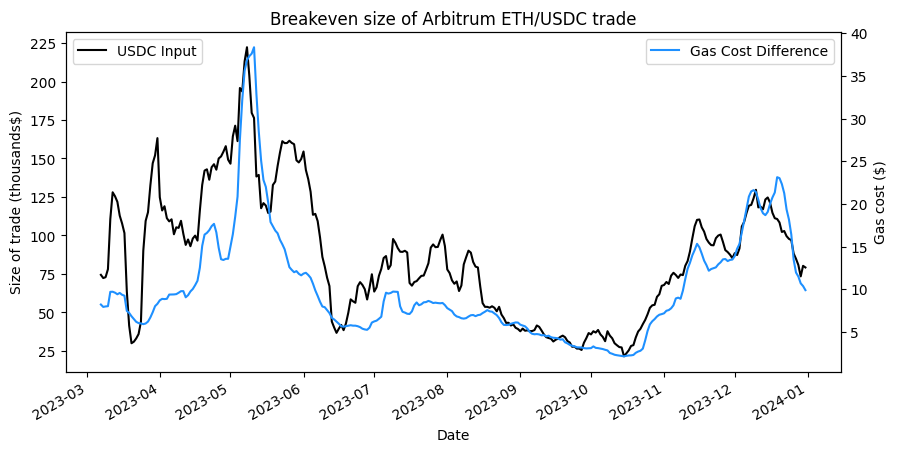

In [14]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(costs['date'], costs['adjCost'], color = 'black', label = 'USDC Input')
ax.set_ylabel("Size of trade (thousands$)")
ax.set_xlabel("Date")

ax2 = ax.twinx()
ax2.plot(costs['date'], costs['adjAmtInDifference'], color = 'dodgerblue', label = "Gas Cost Difference")
ax2.set_ylabel("Gas cost ($)")

ax.set_title("Breakeven size of Arbitrum ETH/USDC trade")
ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')

fig.autofmt_xdate()
fig.savefig("breakeven_cost.png")

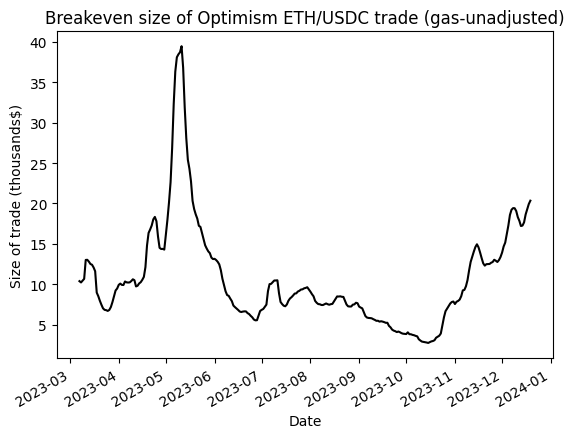

In [27]:
fig, ax = plt.subplots()

ax.plot(costs['date'], costs['adjAmtInDifference'], color = 'black')
ax.set_ylabel("Size of trade (thousands$)")
ax.set_xlabel("Date")
ax.set_title("Breakeven size of Optimism ETH/USDC trade (gas-unadjusted)")

fig.autofmt_xdate()
#fig.savefig("breakeven_cost_op.pdf")